In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
REWARD = 100

In [5]:
seed = 4507
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 0 #masscart, masspole, length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [6]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  U7QE8IKW_00_21_46
NN-MODEL FILENAME:  ./models/U7QE8IKW_00_21_46_NN.pt


In [7]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [8]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s     = borders
    
    indx = np.empty_like(value).astype(np.intp)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax().astype(np.intp)
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.intp)
    return indx



In [9]:
T_LR           = 1e-2
T_GAMMA        = 0.99
T_EPSILON      = 0.98

NO_OF_NODES    = 10
NO_OF_EPISODES = 100
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  10
Number of EPISODES per NODE 100


In [10]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-3  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 500   # target update frequency
MIN_MEMORY_CAP      = 200000

In [11]:
MAX_NO_OF_ITERATIONS = 50
MAX_NN_ITERATIONS    = 50000
print("Number of ITERATIONS: ",MAX_NO_OF_ITERATIONS)

Number of ITERATIONS:  50


In [12]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.memory_counter      = 0
        self.memory              = np.zeros((int(MIN_MEMORY_CAP), N_STATES * 2 + 2)) # initialize memory
        
#         self.good_memory_counter = 0 # for storing non-terminal memories
#         self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
#         self.bad_memory_counter  = 0 # for storing terminal memories
#         self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        self.running_loss        = 0
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action
    
    def get_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions = self.eval_net.forward(x).view(-1,N_ACTIONS).max(1)[1].data.numpy().astype(np.intp)
#         actions_value 
#         action = torch.max(actions_value, 1)[1].data.numpy()
#         action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return actions
    
    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1
        
        sample_index_limit = min(MIN_MEMORY_CAP, self.memory_counter)
        sample_index = np.random.choice(int(sample_index_limit),int(BATCH_SIZE))
        b_memory = self.memory[sample_index,:]
#         # sample batch transitions
#         good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
#         bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

#         good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
#         bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

#         b_good_memory = self.good_memory[good_sample_index, :]
#         b_bad_memory  = self.bad_memory[bad_sample_index, :]
#         b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.running_loss += loss.mean().item()
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            print('LOSS : %.3f' %(self.running_loss / TARGET_REPLACE_ITER), end="\t")
            self.running_loss = 0.0

In [13]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [14]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.6
C_POS_ABS_MIN = -2.6

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  6
P_VEL_ABS_MIN = -6

In [15]:
# SET GRANULARITY
HI_GRAIN = 40
print("HI_GRAIN = ", HI_GRAIN)

HI_GRAIN =  40


In [16]:
def mp_node_run(node_id, boundary, iteration, node_q_table):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################


    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_ABS_MIN,  C_POS_ABS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_ABS_MIN,  C_VEL_ABS_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_ABS_MIN,  P_ANG_ABS_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_ABS_MIN,  P_VEL_ABS_MAX,  HI_GRAIN)

    borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s]
    ###############################################
    
    my_Q_TABLE = node_q_table

    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    
#     if iteration < 3:
    my_EPSILON   = np.clip(((3%5 + 1)*0.1 + (iteration)*0.2) ,0.4,0.98)+ np.random.uniform(-0.01,0.01)
#     print(node_id, my_EPSILON)
#     else:
#         my_EPSILON   = T_EPSILON + np.random.uniform(-0.01,0.01)
    
    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0
            
            s = my_env.reset()
            
            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = (node_id%N_ACTIONS)#np.random.randint(0, N_ACTIONS)
                else:
                    a = my_Q_TABLE[this_state]

                 # take action
                s_, r, done, info = my_env.step(a)

                if done:
                    r = -REWARD
                    if time_steps >= TIMESTEP_LIMIT:
                        r = REWARD
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, borders))
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)
    
    # GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX] = [exp_rec[:,i].max() for i in range(N_STATES)]
    [C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN] = [exp_rec[:,i].min() for i in range(N_STATES)]

    newboundary = [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX,
                   C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN]
    
    return exp_rec, time_rec, newboundary

In [17]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [18]:
iteration = 0
# my_dqn = D3QN()
dqn = D3QN()

# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN]



# CREATE STATE COMBINATIONS
# ###############################################

init_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN],
                                    [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN])



# # GET Q-VALUES 
start = timeit.default_timer()
%memit init_q_table = dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN).astype(np.intp)
stop = timeit.default_timer()
print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# SAVE QFILE
# node_QFILE = './Q_NPY/' + RNDM_STRING + 'QFILE' + ".npy"
# np.save(node_QFILE, init_q_table)

peak memory: 1265.46 MiB, increment: 1045.66 MiB
Quantization TIME:  0.02 minutes


In [19]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES
node_q_table = init_q_table



ITERATION # 0
TOTAL EXPERIENCE GENERATED:   14870
SMALLEST TIMESTEP: 8
LARGEST  TIMESTEP: 98
TOTAL SERIAL TIMESTEPS:   14870
TOTAL PARALLEL TIMESTEPS: 98


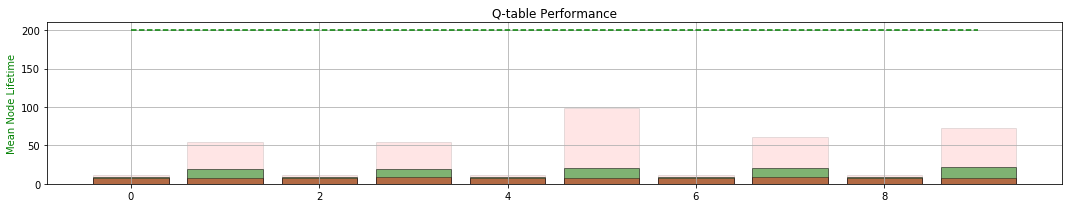

MEMORY COUNTER:  14870
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 577.274	LOSS : 517.737	LOSS : 512.169	LOSS : 506.994	LOSS : 482.103	LOSS : 487.737	LOSS : 493.739	LOSS : 488.064	LOSS : 467.824	LOSS : 479.884	LOSS : 458.718	LOSS : 455.200	LOSS : 439.700	LOSS : 447.116	LOSS : 435.932	LOSS : 420.377	LOSS : 420.444	LOSS : 428.804	LOSS : 425.133	LOSS : 394.962	
Validating... MEAN TIME:  136.625
LOSS : 395.402	LOSS : 412.844	LOSS : 391.955	LOSS : 375.979	LOSS : 377.185	LOSS : 387.168	LOSS : 381.887	LOSS : 395.402	LOSS : 383.887	LOSS : 388.361	LOSS : 391.000	LOSS : 360.371	LOSS : 364.935	LOSS : 365.207	LOSS : 373.493	LOSS : 352.944	LOSS : 354.636	LOSS : 359.573	LOSS : 351.918	LOSS : 357.484	
Validating... MEAN TIME:  135.595
LOSS : 355.065	LOSS : 362.436	LOSS : 348.102	LOSS : 363.875	LOSS : 358.015	LOSS : 342.213	LOSS : 357.716	LOSS : 360.765	LOSS : 354.353	LOSS : 341.818	LOSS : 351.971	LOSS : 343.745	LOSS : 344.933	LOSS : 338.729	LOSS : 346.601	LOSS : 351.052	LOSS : 3

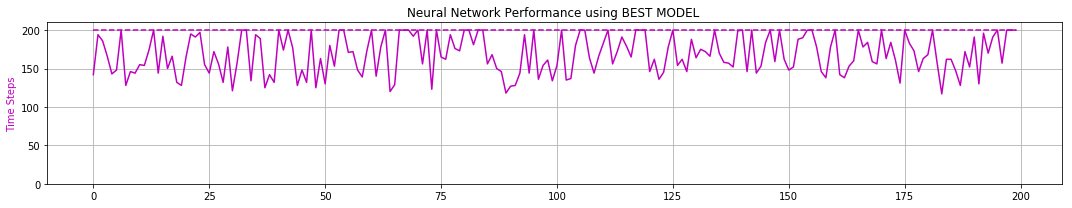

peak memory: 1322.33 MiB, increment: 1045.36 MiB
0 -max- [ 0.050  0.049  0.209  2.947]
0 -min- [-0.186 -1.974 -0.047 -0.050]

1 -max- [ 0.617  2.320  0.209  2.044]
1 -min- [-0.231 -1.332 -0.209 -2.907]

2 -max- [ 0.049  0.048  0.209  2.954]
2 -min- [-0.192 -1.965 -0.049 -0.045]

3 -max- [ 0.523  2.048  0.209  1.863]
3 -min- [-0.179 -1.128 -0.209 -2.837]

4 -max- [ 0.050  0.050  0.207  2.953]
4 -min- [-0.192 -1.913 -0.049 -0.049]

5 -max- [ 0.593  1.937  0.209  2.447]
5 -min- [-0.221 -1.562 -0.209 -2.698]

6 -max- [ 0.049  0.050  0.209  2.944]
6 -min- [-0.222 -1.973 -0.050 -0.049]

7 -max- [ 0.522  2.467  0.209  2.427]
7 -min- [-0.181 -1.598 -0.209 -2.622]

8 -max- [ 0.049  0.049  0.209  2.968]
8 -min- [-0.223 -1.996 -0.049 -0.048]

9 -max- [ 0.735  2.619  0.208  2.135]
9 -min- [-0.261 -1.591 -0.209 -2.887]

Quantization TIME:  0.01 minutes


ITERATION # 1
TOTAL EXPERIENCE GENERATED:   45632
SMALLEST TIMESTEP: 8
LARGEST  TIMESTEP: 170
TOTAL SERIAL TIMESTEPS:   60502
TOTAL PARALLEL TIMES

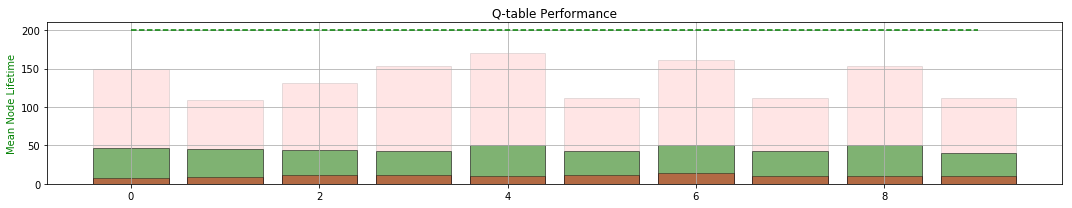

MEMORY COUNTER:  60502
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 418.791	LOSS : 398.081	LOSS : 404.587	LOSS : 382.441	LOSS : 389.387	LOSS : 369.600	LOSS : 353.750	LOSS : 349.563	LOSS : 358.926	LOSS : 354.043	LOSS : 361.648	LOSS : 343.986	LOSS : 346.574	LOSS : 348.785	LOSS : 322.513	LOSS : 317.612	LOSS : 318.459	LOSS : 323.287	LOSS : 316.075	LOSS : 321.344	
Validating... MEAN TIME:  169.695
LOSS : 314.383	LOSS : 325.204	LOSS : 315.487	LOSS : 331.452	LOSS : 351.841	LOSS : 333.897	LOSS : 325.081	LOSS : 314.107	LOSS : 332.756	LOSS : 318.049	LOSS : 321.288	LOSS : 324.479	LOSS : 346.801	LOSS : 334.140	LOSS : 336.713	LOSS : 322.291	LOSS : 325.016	LOSS : 350.381	LOSS : 331.794	LOSS : 339.599	
Validating... MEAN TIME:  191.235
LOSS : 348.561	LOSS : 342.409	LOSS : 344.018	LOSS : 350.792	LOSS : 349.083	LOSS : 347.422	LOSS : 359.516	LOSS : 368.369	LOSS : 359.693	LOSS : 361.359	LOSS : 378.433	LOSS : 359.527	LOSS : 404.772	LOSS : 379.683	LOSS : 387.756	LOSS : 377.311	LOSS : 3

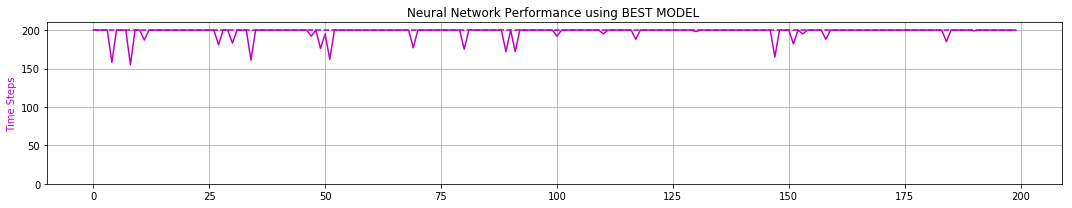

peak memory: 1384.45 MiB, increment: 1046.00 MiB
0 -max- [ 1.929  2.400  0.209  2.364]
0 -min- [-0.521 -1.948 -0.064 -1.335]

1 -max- [ 0.208  1.419  0.050  1.297]
1 -min- [-0.797 -1.512 -0.209 -2.284]

2 -max- [ 1.137  2.200  0.209  2.469]
2 -min- [-0.225 -1.604 -0.050 -1.642]

3 -max- [ 0.207  1.400  0.048  1.100]
3 -min- [-0.807 -1.414 -0.209 -2.338]

4 -max- [ 1.464  2.381  0.209  2.225]
4 -min- [-1.157 -1.927 -0.209 -1.758]

5 -max- [ 0.255  1.400  0.050  1.163]
5 -min- [-0.849 -1.712 -0.209 -2.319]

6 -max- [ 1.318  2.208  0.209  2.378]
6 -min- [-0.888 -1.383 -0.197 -1.265]

7 -max- [ 0.342  1.779  0.050  1.014]
7 -min- [-0.839 -1.485 -0.209 -2.539]

8 -max- [ 1.981  2.428  0.209  2.711]
8 -min- [-0.302 -1.724 -0.050 -1.835]

9 -max- [ 0.189  1.540  0.050  1.264]
9 -min- [-0.889 -1.669 -0.209 -2.383]

Quantization TIME:  0.02 minutes


ITERATION # 2
TOTAL EXPERIENCE GENERATED:   92858
SMALLEST TIMESTEP: 10
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   153360
TOTAL PARALLEL TIM

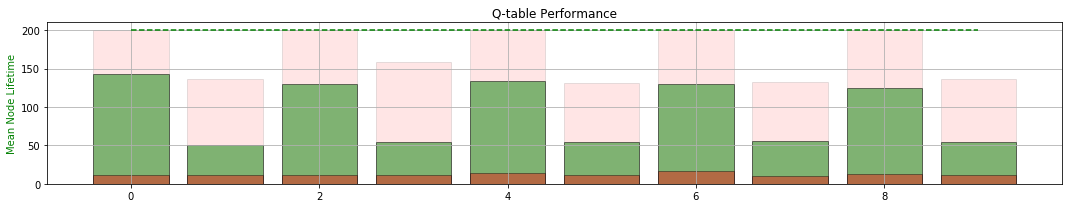

MEMORY COUNTER:  153360
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 551.684	LOSS : 531.447	LOSS : 508.561	LOSS : 447.742	LOSS : 428.671	LOSS : 415.880	LOSS : 409.123	LOSS : 393.606	LOSS : 379.030	LOSS : 362.701	LOSS : 358.254	LOSS : 354.748	LOSS : 357.171	LOSS : 328.984	LOSS : 327.665	LOSS : 302.241	LOSS : 313.395	LOSS : 318.355	LOSS : 325.415	LOSS : 306.903	
Validating... MEAN TIME:  144.43
LOSS : 315.978	LOSS : 304.058	LOSS : 316.637	LOSS : 299.484	LOSS : 294.191	LOSS : 293.511	LOSS : 275.930	LOSS : 303.417	LOSS : 310.281	LOSS : 295.228	LOSS : 275.100	LOSS : 291.047	LOSS : 283.033	LOSS : 289.474	LOSS : 287.953	LOSS : 302.235	LOSS : 300.012	LOSS : 301.639	LOSS : 285.272	LOSS : 309.791	
Validating... MEAN TIME:  179.53
LOSS : 278.358	LOSS : 290.089	LOSS : 290.116	LOSS : 280.547	LOSS : 281.192	LOSS : 291.041	LOSS : 302.561	LOSS : 306.728	LOSS : 294.880	LOSS : 269.734	LOSS : 297.669	LOSS : 300.135	LOSS : 317.760	LOSS : 273.186	LOSS : 309.676	LOSS : 283.463	LOSS : 30

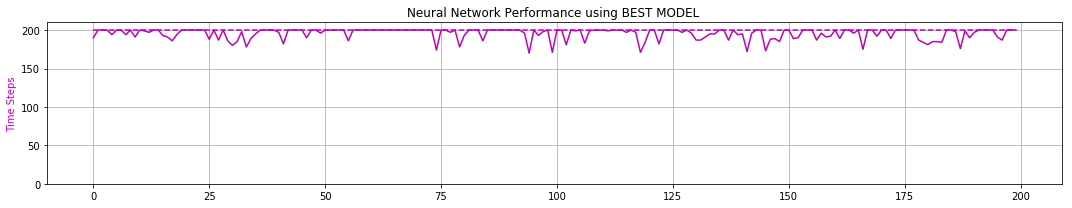

peak memory: 1441.06 MiB, increment: 1018.72 MiB
0 -max- [ 2.398  2.408  0.209  2.688]
0 -min- [-1.537 -2.265 -0.209 -2.257]

1 -max- [ 0.226  1.575  0.078  1.632]
1 -min- [-1.531 -2.184 -0.209 -2.911]

2 -max- [ 2.387  2.452  0.209  2.370]
2 -min- [-1.859 -2.394 -0.209 -2.375]

3 -max- [ 0.189  1.575  0.079  1.627]
3 -min- [-2.389 -2.395 -0.209 -2.373]

4 -max- [ 2.399  2.283  0.209  2.362]
4 -min- [-1.933 -2.316 -0.209 -2.156]

5 -max- [ 0.224  1.373  0.085  1.585]
5 -min- [-1.145 -2.103 -0.209 -2.497]

6 -max- [ 2.048  2.466  0.209  2.317]
6 -min- [-2.379 -2.285 -0.209 -2.555]

7 -max- [ 0.217  1.406  0.083  1.530]
7 -min- [-1.492 -2.245 -0.209 -2.373]

8 -max- [ 2.385  2.597  0.209  2.564]
8 -min- [-1.710 -2.259 -0.208 -2.162]

9 -max- [ 0.211  1.408  0.081  1.640]
9 -min- [-1.280 -2.269 -0.209 -2.229]

Quantization TIME:  0.02 minutes


ITERATION # 3
TOTAL EXPERIENCE GENERATED:   107063
SMALLEST TIMESTEP: 16
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   260423
TOTAL PARALLEL TI

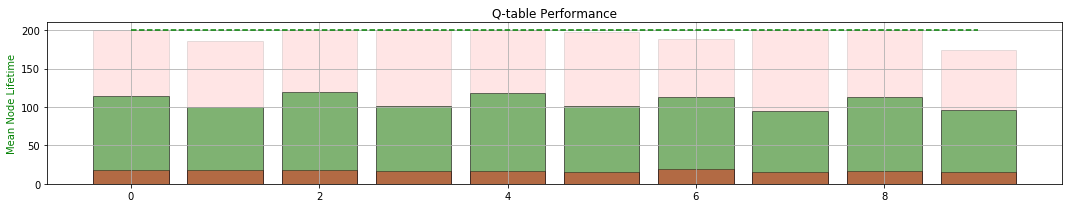

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 244.926	LOSS : 231.229	LOSS : 203.588	LOSS : 189.208	LOSS : 182.432	LOSS : 184.120	LOSS : 185.183	LOSS : 182.846	LOSS : 170.927	LOSS : 143.815	LOSS : 152.167	LOSS : 155.227	LOSS : 156.657	LOSS : 162.538	LOSS : 155.019	LOSS : 143.420	LOSS : 146.056	LOSS : 143.175	LOSS : 146.721	LOSS : 151.372	
Validating... MEAN TIME:  129.51
LOSS : 143.867	LOSS : 153.779	LOSS : 146.294	LOSS : 140.085	LOSS : 143.422	LOSS : 148.679	LOSS : 146.032	LOSS : 143.470	LOSS : 140.273	LOSS : 148.096	LOSS : 147.249	LOSS : 138.131	LOSS : 130.746	LOSS : 138.338	LOSS : 139.922	LOSS : 141.493	LOSS : 139.856	LOSS : 143.554	LOSS : 148.936	LOSS : 137.211	
Validating... MEAN TIME:  126.96
LOSS : 138.589	LOSS : 152.922	LOSS : 150.945	LOSS : 128.588	LOSS : 151.707	LOSS : 138.438	LOSS : 144.945	LOSS : 137.453	LOSS : 140.188	LOSS : 128.866	LOSS : 129.634	LOSS : 132.519	LOSS : 148.954	LOSS : 140.960	LOSS : 149.253	LOSS : 131.762	LOSS : 13

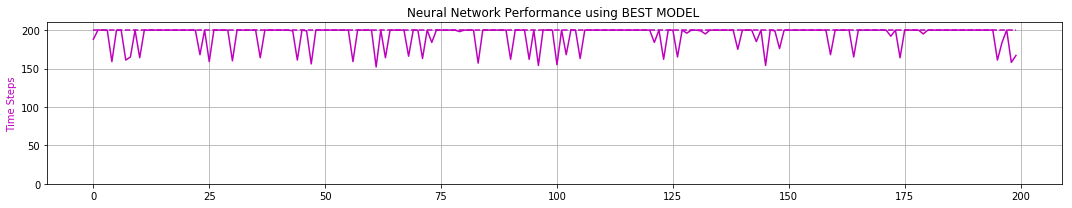

peak memory: 1406.82 MiB, increment: 1033.61 MiB
0 -max- [ 0.372  1.930  0.209  1.990]
0 -min- [-2.400 -2.649 -0.209 -2.280]

1 -max- [ 0.204  1.350  0.153  1.640]
1 -min- [-2.400 -2.604 -0.209 -2.371]

2 -max- [ 0.216  1.525  0.176  1.676]
2 -min- [-2.399 -2.622 -0.209 -2.282]

3 -max- [ 0.210  1.379  0.153  1.636]
3 -min- [-2.399 -2.631 -0.209 -2.439]

4 -max- [ 0.229  1.581  0.185  1.877]
4 -min- [-2.400 -2.551 -0.209 -2.251]

5 -max- [ 0.193  1.376  0.150  1.639]
5 -min- [-2.400 -2.594 -0.209 -2.459]

6 -max- [ 0.279  1.747  0.175  1.898]
6 -min- [-2.399 -2.466 -0.209 -2.261]

7 -max- [ 0.187  1.427  0.150  1.663]
7 -min- [-2.399 -2.782 -0.209 -2.405]

8 -max- [ 0.258  1.580  0.159  1.862]
8 -min- [-2.400 -2.467 -0.209 -2.248]

9 -max- [ 0.191  1.345  0.154  1.640]
9 -min- [-2.399 -2.646 -0.209 -2.341]

Quantization TIME:  0.02 minutes


ITERATION # 4
TOTAL EXPERIENCE GENERATED:   101009
SMALLEST TIMESTEP: 13
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   361432
TOTAL PARALLEL TI

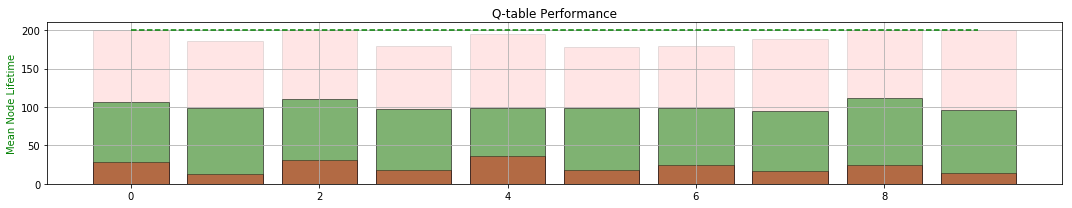

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 141.075	LOSS : 130.444	LOSS : 111.923	LOSS : 137.306	LOSS : 124.200	LOSS : 120.067	LOSS : 131.430	LOSS : 116.617	LOSS : 119.450	LOSS : 111.458	LOSS : 118.346	LOSS : 120.634	LOSS : 120.064	LOSS : 114.803	LOSS : 112.559	LOSS : 102.597	LOSS : 123.154	LOSS : 121.667	LOSS : 112.371	LOSS : 125.507	
Validating... MEAN TIME:  199.93
LOSS : 118.282	LOSS : 119.537	LOSS : 119.745	LOSS : 122.779	LOSS : 117.593	LOSS : 129.144	LOSS : 120.894	LOSS : 116.130	LOSS : 113.427	LOSS : 127.102	LOSS : 125.714	LOSS : 128.884	LOSS : 133.457	LOSS : 125.263	LOSS : 119.601	LOSS : 121.021	LOSS : 119.959	LOSS : 119.211	LOSS : 106.036	LOSS : 112.586	
Validating... MEAN TIME:  200.0
LOSS : 113.912	LOSS : 120.191	LOSS : 114.361	LOSS : 128.107	LOSS : 108.274	LOSS : 126.644	LOSS : 118.080	LOSS : 116.044	LOSS : 112.356	LOSS : 109.196	LOSS : 107.970	LOSS : 111.782	LOSS : 111.636	LOSS : 106.645	LOSS : 121.657	LOSS : 118.509	LOSS : 115

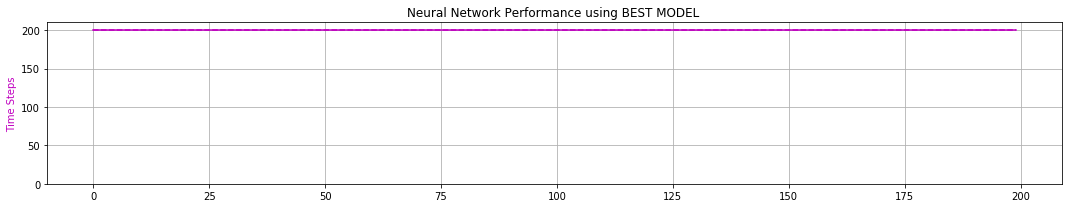

peak memory: 1464.35 MiB, increment: 1017.66 MiB
0 -max- [ 0.190  1.769  0.204  2.045]
0 -min- [-2.399 -2.673 -0.209 -2.281]

1 -max- [ 0.187  1.606  0.172  1.949]
1 -min- [-2.400 -2.674 -0.209 -2.393]

2 -max- [ 0.312  1.607  0.198  2.181]
2 -min- [-2.400 -2.674 -0.209 -2.283]

3 -max- [ 0.210  1.598  0.176  1.953]
3 -min- [-2.400 -2.807 -0.209 -2.283]

4 -max- [ 0.178  1.605  0.202  2.216]
4 -min- [-2.399 -2.612 -0.209 -2.280]

5 -max- [ 0.197  1.607  0.173  1.944]
5 -min- [-2.398 -2.643 -0.209 -2.426]

6 -max- [ 0.427  1.776  0.209  2.214]
6 -min- [-2.398 -2.641 -0.209 -2.283]

7 -max- [ 0.181  1.787  0.176  1.954]
7 -min- [-2.398 -2.646 -0.209 -2.501]

8 -max- [ 0.254  1.739  0.207  2.172]
8 -min- [-2.399 -2.641 -0.209 -2.284]

9 -max- [ 0.187  1.607  0.177  1.954]
9 -min- [-2.399 -2.604 -0.209 -2.313]

Quantization TIME:  0.02 minutes


ITERATION # 5
TOTAL EXPERIENCE GENERATED:   117059
SMALLEST TIMESTEP: 10
LARGEST  TIMESTEP: 172
TOTAL SERIAL TIMESTEPS:   478491
TOTAL PARALLEL TI

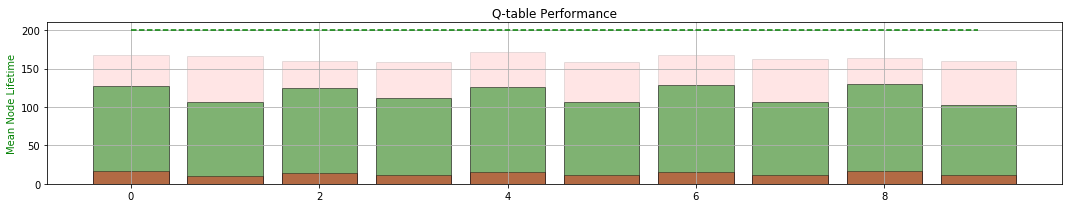

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 112.355	LOSS : 121.169	LOSS : 107.103	LOSS : 102.098	LOSS : 110.967	LOSS : 99.003	LOSS : 98.193	LOSS : 99.295	LOSS : 102.456	LOSS : 98.271	LOSS : 106.506	LOSS : 110.102	LOSS : 105.329	LOSS : 93.648	LOSS : 97.141	LOSS : 106.101	LOSS : 104.863	LOSS : 99.810	LOSS : 105.658	LOSS : 101.223	
Validating... MEAN TIME:  100.835
LOSS : 110.652	LOSS : 93.676	LOSS : 95.880	LOSS : 91.655	LOSS : 96.169	LOSS : 89.455	LOSS : 101.442	LOSS : 103.818	LOSS : 87.367	LOSS : 102.777	LOSS : 100.214	LOSS : 83.428	LOSS : 102.386	LOSS : 101.342	LOSS : 91.666	LOSS : 92.842	LOSS : 92.453	LOSS : 103.171	LOSS : 97.166	LOSS : 89.832	
Validating... MEAN TIME:  115.59
LOSS : 92.008	LOSS : 100.081	LOSS : 94.223	LOSS : 100.442	LOSS : 91.780	LOSS : 83.588	LOSS : 101.503	LOSS : 103.522	LOSS : 107.787	LOSS : 99.340	LOSS : 88.612	LOSS : 92.098	LOSS : 92.907	LOSS : 94.631	LOSS : 97.499	LOSS : 94.734	LOSS : 92.121	LOSS : 84.426	LOSS : 99.

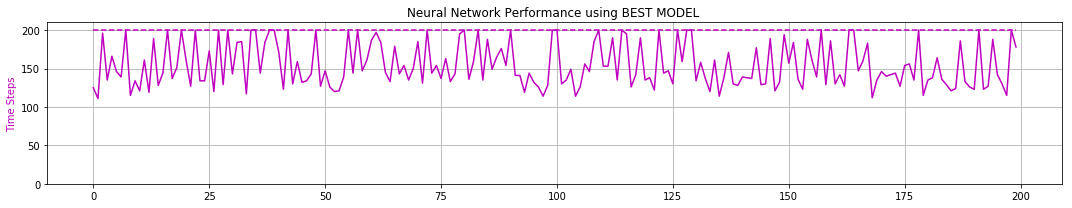

peak memory: 1504.90 MiB, increment: 1034.00 MiB
0 -max- [ 0.189  1.196  0.085  0.955]
0 -min- [-2.399 -2.577 -0.209 -1.675]

1 -max- [ 0.221  1.207  0.082  0.835]
1 -min- [-2.400 -2.589 -0.209 -1.828]

2 -max- [ 0.223  1.218  0.091  0.919]
2 -min- [-2.400 -2.618 -0.209 -1.676]

3 -max- [ 0.193  1.212  0.081  0.720]
3 -min- [-2.400 -2.725 -0.209 -1.680]

4 -max- [ 0.212  1.215  0.097  0.993]
4 -min- [-2.399 -2.612 -0.209 -1.677]

5 -max- [ 0.206  1.386  0.080  0.713]
5 -min- [-2.399 -2.604 -0.209 -1.969]

6 -max- [ 0.206  1.202  0.084  0.971]
6 -min- [-2.400 -2.713 -0.209 -1.682]

7 -max- [ 0.205  1.162  0.082  0.788]
7 -min- [-2.400 -2.608 -0.209 -1.673]

8 -max- [ 0.200  1.182  0.088  0.929]
8 -min- [-2.400 -2.614 -0.206 -1.673]

9 -max- [ 0.218  1.193  0.082  0.935]
9 -min- [-2.399 -2.697 -0.209 -1.717]

Quantization TIME:  0.02 minutes


ITERATION # 6
TOTAL EXPERIENCE GENERATED:   107553
SMALLEST TIMESTEP: 54
LARGEST  TIMESTEP: 126
TOTAL SERIAL TIMESTEPS:   586044
TOTAL PARALLEL TI

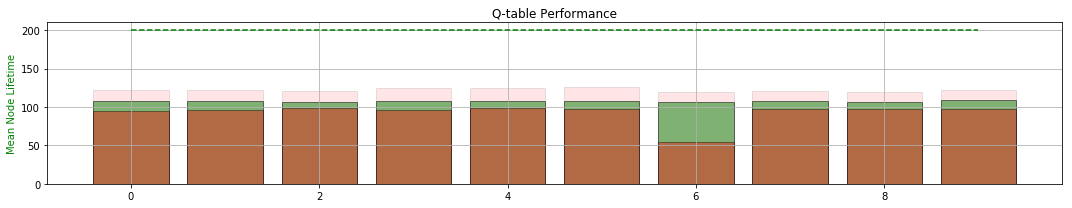

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 93.432	LOSS : 79.309	LOSS : 74.798	LOSS : 80.641	LOSS : 73.844	LOSS : 73.709	LOSS : 73.531	LOSS : 81.270	LOSS : 70.005	LOSS : 69.919	LOSS : 72.039	LOSS : 77.026	LOSS : 73.034	LOSS : 76.230	LOSS : 82.629	LOSS : 66.840	LOSS : 74.224	LOSS : 71.282	LOSS : 74.887	LOSS : 65.431	
Validating... MEAN TIME:  199.425
LOSS : 70.139	LOSS : 80.580	LOSS : 85.261	LOSS : 73.723	LOSS : 78.272	LOSS : 70.797	LOSS : 90.016	LOSS : 79.945	LOSS : 70.227	LOSS : 71.225	LOSS : 75.554	LOSS : 72.854	LOSS : 72.376	LOSS : 73.504	LOSS : 73.679	LOSS : 78.000	LOSS : 73.771	LOSS : 71.395	LOSS : 68.742	LOSS : 81.047	
Validating... MEAN TIME:  104.595
LOSS : 65.345	LOSS : 77.492	LOSS : 77.658	LOSS : 84.177	LOSS : 78.916	LOSS : 73.225	LOSS : 75.664	LOSS : 70.194	LOSS : 64.794	LOSS : 86.691	LOSS : 76.075	LOSS : 67.041	LOSS : 83.131	LOSS : 72.524	LOSS : 84.307	LOSS : 84.828	LOSS : 79.591	LOSS : 75.572	LOSS : 74.917	LOSS : 75.076	
Valida

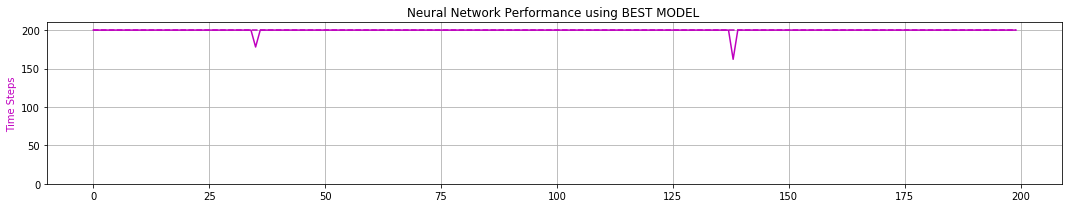

peak memory: 1454.92 MiB, increment: 1036.80 MiB
0 -max- [ 2.232  2.825  0.151  1.365]
0 -min- [-0.144 -0.991 -0.209 -1.681]

1 -max- [ 2.119  2.829  0.139  1.208]
1 -min- [-0.158 -0.828 -0.209 -1.781]

2 -max- [ 2.145  2.837  0.164  1.448]
2 -min- [-0.151 -0.962 -0.209 -1.685]

3 -max- [ 2.129  2.846  0.138  1.359]
3 -min- [-0.117 -0.948 -0.209 -1.768]

4 -max- [ 2.199  2.981  0.162  1.467]
4 -min- [-0.153 -1.017 -0.209 -1.866]

5 -max- [ 2.118  2.812  0.138  1.227]
5 -min- [-0.140 -0.826 -0.209 -1.782]

6 -max- [ 2.185  2.973  0.202  1.463]
6 -min- [-0.141 -0.994 -0.209 -1.722]

7 -max- [ 2.116  2.991  0.140  1.625]
7 -min- [-0.169 -1.172 -0.209 -1.971]

8 -max- [ 2.236  2.819  0.181  1.250]
8 -min- [-0.152 -0.826 -0.209 -1.677]

9 -max- [ 2.167  2.820  0.139  1.214]
9 -min- [-0.129 -0.829 -0.209 -1.787]

Quantization TIME:  0.01 minutes


ITERATION # 7
TOTAL EXPERIENCE GENERATED:   195193
SMALLEST TIMESTEP: 20
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   781237
TOTAL PARALLEL TI

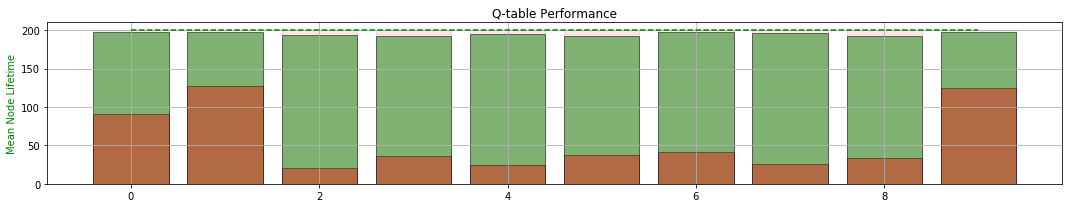

In [20]:
while iteration < MAX_NO_OF_ITERATIONS:

    print("\n")
    print("ITERATION #", iteration)
    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    q_table_list = [node_q_table]* NO_OF_NODES
    iter_list = [iteration] * NO_OF_NODES
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries, iter_list, q_table_list)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)
    
    print("TOTAL EXPERIENCE GENERATED:   {:d}".format(EXP_GEN.astype(int)))

    print("SMALLEST TIMESTEP: {:d}".format(node_time_rec.min().astype(int)))
    print("LARGEST  TIMESTEP: {:d}".format(node_time_rec.max().astype(int)))

    print("TOTAL SERIAL TIMESTEPS:   {:d}".format(total_serial_timesteps.astype(int)))
    print("TOTAL PARALLEL TIMESTEPS: {:d}".format(total_parallel_timesteps.astype(int)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_avg_time[node_avg_time >= 195].shape[0] > NO_OF_NODES/2:
        final_result = "SUCCESS"
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    dqn.memory = np.insert(dqn.memory,0,all_exp,0)
    dqn.memory = dqn.memory[:MIN_MEMORY_CAP,:]
    dqn.memory_counter += all_exp.shape[0]
#     good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
#     bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


#     dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
#     dqn.good_memory_counter += good_mem.shape[0]

#     dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
#     dqn.bad_memory_counter += bad_mem.shape[0]

#     dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
#     dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS
    print("MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.memory_counter))

#     print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
#     print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("\nValidating... ",end="")
            time_rec = []
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()

                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)

                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                nn_level_up_metric = clamp(0, nn_level_up_metric, 195)
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        time_step = 0
        s = env.reset()

        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    
    
        
    ##################################################################
    
    # CREATE ONE LARGE Q-TABLES FROM WHICH THE NODES STRIP
    ##################################################################
        
#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN * NO_OF_NODES  ])
    
    start = timeit.default_timer()
    # GET Q-VALUES 
    %memit node_q_table = best_dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN).astype(np.intp)

    # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
    stop = timeit.default_timer()

#     ##################################################################
    
#     # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
#     ##################################################################
    
    for node_id in range(NO_OF_NODES):
# #         # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
# #         ###############################################
#         [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
#          C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = node_boundaries[node_id]
# #         ###############################################
        print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
        print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
        print("")
        
# #         node_boundaries[node_id] = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_MAX,
# #                                     C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_MIN]
# #         # CREATE STATE COMBINATIONS
# #         ###############################################

#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
#         ###############################################
#     start = timeit.default_timer()
#     # GET Q-VALUES 
#     %memit node_q_table = best_dqn.get_qvals(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1).astype(np.float16)

#     # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
#         #############################################################################################################################################
#     stop = timeit.default_timer()
    print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    iteration += 1
pool.close()
pool.join()

In [21]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

Total Parallel Timesteps :  1366.0
Total Serial Timesteps   :  781237.0
Speed-up                 :  571.92


In [22]:
pool.close()
pool.join()
if iteration == MAX_NO_OF_ITERATIONS:
    final_result = "FAILURE"

In [23]:
print("{:6d} {} {:3d} {:3d} {:7d} {:10d} {:10.2f}".format(seed, final_result, int(node_min_time.min()), int(iteration), int(total_parallel_timesteps), int(total_serial_timesteps), total_serial_timesteps/total_parallel_timesteps))

  4507 SUCCESS  20   7    1366     781237     571.92
